## Set up env

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

TENSOR_SIZE = 1_024_000
TENSORS_PER_DATASET = 4
DARK_MODE = False

## Load Results

In [12]:
# From binary files over the file system
results_fs = pd.read_csv("../aggregation-scaling-py-fs-batch/results/aggregation-scaling-py-fs-batch-2022-10-07.csv")

# From 48 threads per 60 clients when using a 32 thread per 16 node Redis Orchestrator
results_redis_16 = pd.read_csv("../4_1mb_tensors/aggregation-scaling-py-redis-16-batch/results/aggregation-scaling-py-redis-16-batch-2022-10-11.csv")
# From 48 threads per 60 clients when using a 32 thread per 32 node Redis Orchestrator
results_redis_32 = pd.read_csv("../4_1mb_tensors/aggregation-scaling-py-redis-32-batch/results/aggregation-scaling-py-redis-32-batch-2022-10-11.csv")

# From 48 threads per 60 clients when using a 32 thread per 16 node KeyDB Orchestrator
results_keydb_16 = pd.read_csv("../4_1mb_tensors/aggregation-scaling-py-key-16-batch/results/aggregation-scaling-py-key-16-batch-2022-10-11.csv")
# From 48 threads per 60 clients when using a 32 thread per 32 node KeyDB Orchestrator
results_keydb_32 = pd.read_csv("../4_1mb_tensors/aggregation-scaling-py-key-32-batch/results/aggregation-scaling-py-key-32-batch-2022-10-11.csv")


## Filter Results

In [13]:
results_fs = results_fs[(results_fs["tensor_bytes"] == TENSOR_SIZE) & (results_fs["t_per_dataset"] == TENSORS_PER_DATASET)]
results_redis_16 = results_redis_16[(results_redis_16["tensor_bytes"] == TENSOR_SIZE) & (results_redis_16["t_per_dataset"] == TENSORS_PER_DATASET)]
results_redis_32 = results_redis_32[(results_redis_32["tensor_bytes"] == TENSOR_SIZE) & (results_redis_32["t_per_dataset"] == TENSORS_PER_DATASET)]
results_keydb_16 = results_keydb_16[(results_keydb_16["tensor_bytes"] == TENSOR_SIZE) & (results_keydb_16["t_per_dataset"] == TENSORS_PER_DATASET)]
results_keydb_32 = results_keydb_32[(results_keydb_32["tensor_bytes"] == TENSOR_SIZE) & (results_keydb_32["t_per_dataset"] == TENSORS_PER_DATASET)]

### Cursory Look at Results

In [14]:
filters = ["client_threads", "get_list_mean", "loop_time"]
(
    pd.merge(
        results_fs.filter(filters),
        results_redis_16.filter(filters),
        how="inner",
        on="client_threads",
        suffixes=(None, "_redis_16"),
    )
    .merge(
        results_keydb_32.filter(filters),
        how="inner",
        on="client_threads",
        suffixes=(None, "_redis_32")
    )
    .merge(
        results_keydb_16.filter(filters),
        how="inner",
        on="client_threads",
        suffixes=(None, "_keydb_16")
    )
    .merge(
        results_keydb_32.filter(filters),
        how="inner",
        on="client_threads",
        suffixes=(None, "_keydb_32"),
    )
    .rename(columns={
        "get_list_mean": "get_list_mean_fs",
        "loop_time": "loop_time_fs",
    })
    .sort_values("client_threads")
)

,client_threads,get_list_mean_fs,loop_time_fs,get_list_mean_redis_16,loop_time_redis_16,get_list_mean_redis_32,loop_time_redis_32,get_list_mean_keydb_16,loop_time_keydb_16,get_list_mean_keydb_32,loop_time_keydb_32
5,1,292.404074,5931.302395,45.510888,933.688209,74.056899,1507.877728,41.282547,864.429354,74.056899,1507.877728
0,2,170.890232,3501.891622,24.086804,514.710097,38.628376,796.897871,22.579015,472.622118,38.628376,796.897871
2,4,115.382940,2396.311068,13.324377,290.945971,20.531650,435.867276,12.741331,284.953725,20.531650,435.867276
3,8,92.188594,1927.303270,8.331711,189.236700,11.820698,257.939992,8.070015,183.984052,11.820698,257.939992
4,16,76.684533,1619.035405,6.033627,150.117243,7.642517,180.448871,5.659973,134.592571,7.642517,180.448871
1,32,72.190732,1535.169629,6.219164,149.494738,6.136555,146.747323,5.889435,139.870367,6.136555,146.747323


## Plot the Findings

### Set up the graph style

In [15]:
sns.set_palette("colorblind", color_codes=True)
plt.style.use("dark_background" if DARK_MODE else "default")

### Concat the results

In [16]:
concatenated = pd.concat([
    results_fs.assign(backend="File System"),
    results_redis_16.assign(backend="16 Redis Nodes"),
    results_redis_32.assign(backend="32 Redis Nodes"),
    results_keydb_16.assign(backend="16 KeyDB Nodes"),
    results_keydb_32.assign(backend="32 KeyDB Nodes"),
])

### Get List Average Runtime

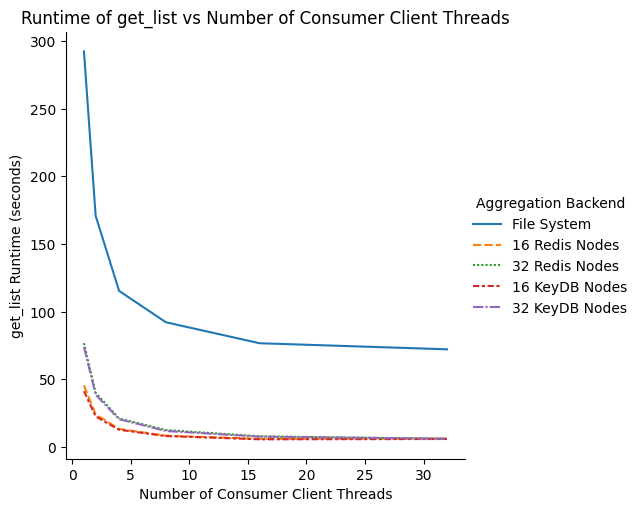

In [17]:
(
    sns.relplot(
        data=concatenated,
        kind="line",
        x="client_threads",
        y="get_list_mean",
        hue="backend",
        style="backend",
    )
    .set(
        title="Runtime of get_list vs Number of Consumer Client Threads",
        xlabel="Number of Consumer Client Threads",
        ylabel="get_list Runtime (seconds)",
    )
    .legend
    .set_title("Aggregation Backend")
)

### Get List Loop Runtime

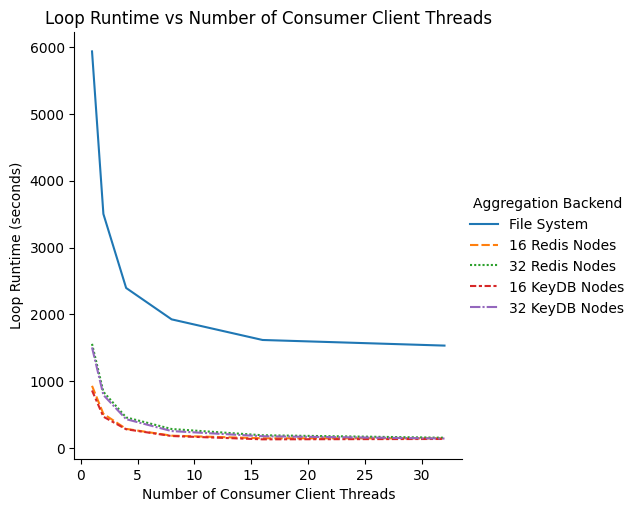

In [18]:
(
    sns.relplot(
        data=concatenated,
        kind="line",
        x="client_threads",
        y="loop_time",
        hue="backend",
        style="backend",
    )
    .set(
        title="Loop Runtime vs Number of Consumer Client Threads",
        xlabel="Number of Consumer Client Threads",
        ylabel="Loop Runtime (seconds)",
    )
    .legend
    .set_title("Aggregation Backend")
)

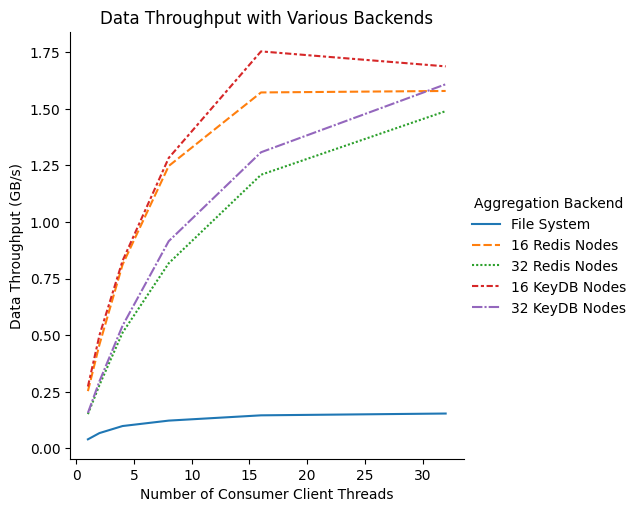

In [19]:
throughput_df = concatenated.copy()
throughput_df["throughput"] = (throughput_df["client_nodes"]
                               * throughput_df["client_per_node"]
                               * throughput_df["tensor_bytes"]
                               * throughput_df["t_per_dataset"]
                               * throughput_df["iterations"]
                               / throughput_df["loop_time"]
                               / 1e9)
(
    sns.relplot(
        data=throughput_df,
        kind="line",
        x="client_threads",
        y="throughput",
        hue="backend",
        style="backend",
    )
    .set(
        title="Data Throughput with Various Backends",
        xlabel="Number of Consumer Client Threads",
        ylabel="Data Throughput (GB/s)",
    )
    .legend
    .set_title("Aggregation Backend")
)

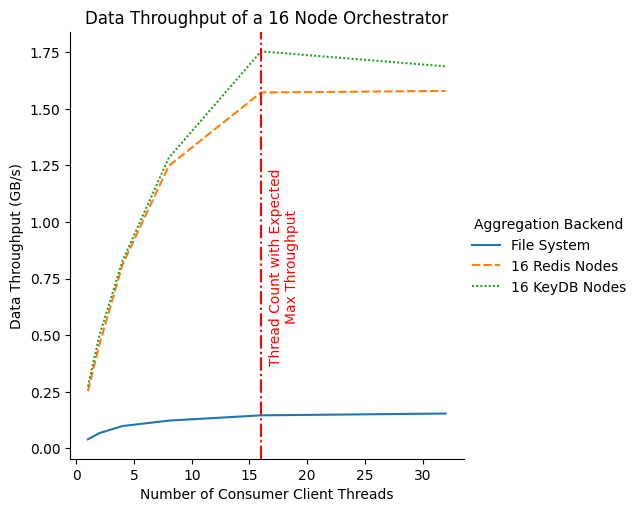

In [20]:
refline_color = "red"
db16_plot = (
    sns.relplot(
        data=throughput_df[throughput_df["backend"].isin([
            "File System",
            "16 Redis Nodes",
            "16 KeyDB Nodes"
        ])],
        kind="line",
        x="client_threads",
        y="throughput",
        hue="backend",
        style="backend",
    )
    .set(
        title="Data Throughput of a 16 Node Orchestrator",
        xlabel="Number of Consumer Client Threads",
        ylabel="Data Throughput (GB/s)",
    )
)
expected_max = 16
ax ,= db16_plot.axes[0]
ax.axvline(expected_max, ls="-.", c=refline_color)
plt.text(
    expected_max + 2,
    0.45,
    "Thread Count with Expected\nMax Throughput",
    transform=ax.get_xaxis_transform(),
    rotation="vertical",
    horizontalalignment="center",
    verticalalignment="center",
    c=refline_color,
)
db16_plot.legend.set_title("Aggregation Backend")
